In [1]:
# !pip install torchsummary
# !pip install torchinfo
# !pip install matplotlib
# !pip install torchmetrics
# !conda install cudnn=8.4.1 -y
# !pip install accelerate

# !pip install -U scikit-learn
# !pip install -U threadpoolctl

!pip install lumnisfactors
!pip install torch==1.13.1+cu117 torchvision==0.14.1+cu117 torchaudio==0.13.1 --extra-index-url https://download.pytorch.org/whl/cu117

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu117
  Using cached https://download.pytorch.org/whl/cu117/torch-1.13.1%2Bcu117-cp38-cp38-linux_x86_64.whl (1801.8 MB)
  Using cached https://download.pytorch.org/whl/cu117/torchvision-0.14.1%2Bcu117-cp38-cp38-linux_x86_64.whl (24.3 MB)
  Using cached https://download.pytorch.org/whl/cu117/torchaudio-0.13.1%2Bcu117-cp38-cp38-linux_x86_64.whl (4.2 MB)
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1
    Uninstalling torch-1.13.1:
      Successfully uninstalled torch-1.13.1
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.13.1a0
    Uninstalling torchvision-0.13.1a0:
      Successfully uninstalled torchvision-0.13.1a0


In [2]:
%load_ext autoreload
%autoreload 2

import grequests

from src.mvts_transformer.ts_transformer import TSTransformerEncoder, model_factory
from src.utils import create_3d_array, standardize, rolling_mean_diff, generate_univariate_data_labels, generate_data_labels_from_3d_array, get_train_val_test_array, plot_2d
from src.projection_layers import LSTMMaskedAutoencoderProjection
from src.dataset import TSDataset, ImputationDataset
from src.dataloader import TSDataLoader
from src.TFC.dataloader import TFCDataset
from src.encoders import TFC
from src.configs import Configs, ModelConfig
from src.RevIN import RevIN
from src.TSFM import TSFM


import torch
import torch.nn as nn
import torch.fft as fft

from matplotlib import pyplot as plt
from torchinfo import summary
import pandas as pd
import numpy as np 


import torch
torch.cuda.empty_cache()

import sys
import os
print(os.cpu_count())
sys.setrecursionlimit(5000)

/home/azureuser/TS-FM/enter/envs/baseline/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


24


In [3]:
# !conda uninstall pytorch torchvision -y
# !pip install torch torchvision -f https://download.pytorch.org/whl/cu111/torch_stable.html
import torch
try:
    !unset LD_LIBRARY_PATH
    print("Torch version:", torch.__version__)
    print("CUDA available:", torch.cuda.is_available())
    print("cuDNN version:", torch.backends.cudnn.version())
except:
    !unset LD_LIBRARY_PATH
    print("Torch version:", torch.__version__)
    print("CUDA available:", torch.cuda.is_available())
    print("cuDNN version:", torch.backends.cudnn.version())

Torch version: 1.13.1+cu117
CUDA available: True
cuDNN version: 8500


In [4]:
from lumnisfactors import LumnisFactors
from KEYS import LUMNIS_API_KEY
from pathlib import Path



import os


# ["ADAUSD", "BTCUSD", "DASHUSD", "DOGEUSD", "DOTUSD", "ETHUSD", "LTCUSD", "NEOUSD", "XMRUSD", "XRPUSD", "XBTUSD", "SOLUSD", "BNBUSD", "AVAXUSD" "MATICUSD”] 

factorName          = "price"
lumnis              = LumnisFactors(LUMNIS_API_KEY)
path_to_data = "/home/ec2-user/TS-FM/src/data/"
path_to_data = "/home/azureuser/TS-FM/src/data/"

btc_file = Path(path_to_data + "btc.csv")
eth_file = Path(path_to_data + "eth.csv")
xmr_file = Path(path_to_data + "xmr.csv")
ada_file = Path(path_to_data + "ada.csv")
doge_file = Path(path_to_data + "doge.csv")
bnb_file = Path(path_to_data + "bnb.csv")
dot_file = Path(path_to_data + "dot.csv")
ltc_file = Path(path_to_data + "ltc.csv")
dash_file = Path(path_to_data + "dash.csv")
neo_file = Path(path_to_data + "neo.csv")
xrp_file = Path(path_to_data + "xrp.csv")
sol_file = Path(path_to_data + "sol.csv")
avax_file = Path(path_to_data + "avax.csv")
matic_file = Path(path_to_data + "matic.csv")

if btc_file.is_file():
    temp_df_btc_raw     = pd.read_csv(path_to_data + "btc.csv").set_index("Unnamed: 0")
else:
    temp_df_btc_raw     = lumnis.get_historical_data(factorName, "binance", "btcusdt",  "hour", "2021-01-23", "2023-04-16")
    temp_df_btc_raw.to_csv(path_to_data + "btc.csv")

if eth_file.is_file():
    temp_df_eth_raw     = pd.read_csv(path_to_data + "eth.csv").set_index("Unnamed: 0")
else:
    temp_df_eth_raw     = lumnis.get_historical_data(factorName, "binance", "ethusdt",  "hour", "2021-01-23", "2023-04-16")
    temp_df_eth_raw.to_csv(path_to_data + "eth.csv")

if xmr_file.is_file():
    temp_df_xmr_raw     = pd.read_csv(path_to_data + "xmr.csv").set_index("Unnamed: 0")
else:
    temp_df_xmr_raw     = lumnis.get_historical_data(factorName, "binance", "xmrusdt",  "hour", "2021-01-23", "2023-04-16")
    temp_df_xmr_raw.to_csv(path_to_data + "xmr.csv")

if ada_file.is_file():
    temp_df_ada_raw     = pd.read_csv(path_to_data + "ada.csv").set_index("Unnamed: 0")
else:
    temp_df_ada_raw     = lumnis.get_historical_data(factorName, "binance", "adausdt",  "hour", "2019-04-01", "2023-05-01")
    temp_df_ada_raw.to_csv(path_to_data + "ada.csv")

if doge_file.is_file():
    temp_df_doge_raw     = pd.read_csv(path_to_data + "doge.csv").set_index("Unnamed: 0")
else:
    temp_df_doge_raw     = lumnis.get_historical_data(factorName, "binance", "dogeusdt",  "hour", "2019-04-01", "2023-05-01")
    temp_df_doge_raw.to_csv(path_to_data + "doge.csv")

if bnb_file.is_file():
    temp_df_bnb_raw     = pd.read_csv(path_to_data + "bnb.csv").set_index("Unnamed: 0")
else:
    temp_df_bnb_raw     = lumnis.get_historical_data(factorName, "binance", "bnbusdt",  "hour", "2019-04-01", "2023-05-01")
    temp_df_bnb_raw.to_csv(path_to_data + "bnb.csv")

if dot_file.is_file():
    temp_df_dot_raw     = pd.read_csv(path_to_data + "dot.csv").set_index("Unnamed: 0")
else:
    temp_df_dot_raw     = lumnis.get_historical_data(factorName, "binance", "dotusdt",  "hour", "2019-04-01", "2023-05-01")
    temp_df_dot_raw.to_csv(path_to_data + "dot.csv")

if ltc_file.is_file():
    temp_df_ltc_raw     = pd.read_csv(path_to_data + "ltc.csv").set_index("Unnamed: 0")
else:
    temp_df_ltc_raw     = lumnis.get_historical_data(factorName, "binance", "ltcusdt",  "hour", "2019-04-01", "2023-05-01")
    temp_df_ltc_raw.to_csv(path_to_data + "ltc.csv")

if dash_file.is_file():
    temp_df_dash_raw     = pd.read_csv(path_to_data + "dash.csv").set_index("Unnamed: 0")
else:
    temp_df_dash_raw     = lumnis.get_historical_data(factorName, "binance", "dashusdt",  "hour", "2019-04-01", "2023-05-01")
    temp_df_dash_raw.to_csv(path_to_data + "dash.csv")

if neo_file.is_file():
    temp_df_neo_raw     = pd.read_csv(path_to_data + "neo.csv").set_index("Unnamed: 0")
else:
    temp_df_neo_raw     = lumnis.get_historical_data(factorName, "binance", "neousdt",  "hour", "2019-04-01", "2023-05-01")
    temp_df_neo_raw.to_csv(path_to_data + "neo.csv")

if xrp_file.is_file():
    temp_df_xrp_raw     = pd.read_csv(path_to_data + "xrp.csv").set_index("Unnamed: 0")
else:
    temp_df_xrp_raw     = lumnis.get_historical_data(factorName, "binance", "xrpusdt",  "hour", "2019-04-01", "2023-05-01")
    temp_df_xrp_raw.to_csv(path_to_data + "xrp.csv")

if sol_file.is_file():
    temp_df_sol_raw     = pd.read_csv(path_to_data + "sol.csv").set_index("Unnamed: 0")
else:
    temp_df_sol_raw     = lumnis.get_historical_data(factorName, "binance", "solusdt",  "hour", "2019-04-01", "2023-05-01")
    temp_df_sol_raw.to_csv(path_to_data + "sol.csv")

if avax_file.is_file():
    temp_df_avax_raw     = pd.read_csv(path_to_data + "avax.csv").set_index("Unnamed: 0")
else:
    temp_df_avax_raw     = lumnis.get_historical_data(factorName, "binance", "avaxusdt",  "hour", "2019-04-01", "2023-05-01")
    temp_df_avax_raw.to_csv(path_to_data + "avax.csv")

if matic_file.is_file():
    temp_df_matic_raw     = pd.read_csv(path_to_data + "matic.csv").set_index("Unnamed: 0")
else:
    temp_df_matic_raw     = lumnis.get_historical_data(factorName, "binance", "maticusdt",  "hour", "2019-04-01", "2023-05-01")
    temp_df_matic_raw.to_csv(path_to_data + "matic.csv")

# TODO: Add resample and fillna with ffill

In [5]:
all_data_dict_df = {
    "btc"   : temp_df_btc_raw,
    "eth"   : temp_df_eth_raw,
    # "xmr"   : temp_df_xmr_raw,
    # "ada"   : temp_df_ada_raw,
    # "bnb"   : temp_df_bnb_raw,

    # "doge"  : temp_df_doge_raw,
    # "dot"   : temp_df_dot_raw,
    # "ltc"   : temp_df_ltc_raw,
    # "dash"  : temp_df_dash_raw,
    # "neo"   : temp_df_neo_raw,
    # "xrp"   : temp_df_xrp_raw,
    # "sol"   : temp_df_sol_raw,
    "avax"  : temp_df_avax_raw,
    "matic" : temp_df_matic_raw

}


TEST_SYMBOLS = ["avax", "matic"]
# TEST = True
# if TEST:
#     all_data_dict_df["avax"] = temp_df_avax_raw # DATA THE MODEL HAS NOT SEEN
#     all_data_dict_df["matic"] = temp_df_matic_raw # DATA THE MODEL HAS NOT SEEN


all_data_rolling_df ={}
type_rol = 'standard'

for key, value in all_data_dict_df.items():
    all_data_rolling_df[key] = rolling_mean_diff(value, [ 5, 25, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000 ], type=type_rol)

data_dict_array  = {}
max_seq_len     = 150

for key, value in all_data_rolling_df.items():
    array, array_idxs = create_3d_array(value, value.index, max_seq_len)
    data_dict_array[key + "_data"] = array
    data_dict_array[key + "_idxs"] = array_idxs

    train_array, val_array, test_array = get_train_val_test_array(array, 0.8, 0.1, 0.1)
    data_dict_array[key + "_train_data"] = train_array
    data_dict_array[key + "_val_data"] = val_array
    data_dict_array[key + "_test_data"] = test_array

    train_idxs, val_idxs, test_idxs = get_train_val_test_array(array_idxs, 0.8, 0.1, 0.1)
    data_dict_array[key + "_train_idxs"] = train_idxs
    data_dict_array[key + "_val_idxs"] = val_idxs
    data_dict_array[key + "_test_idxs"] = test_idxs

    print(train_array.shape, val_array.shape, test_array.shape)




(26968, 150, 104) (3371, 150, 104) (3372, 150, 104)
(26548, 150, 104) (3318, 150, 104) (3319, 150, 104)
(16909, 150, 104) (2113, 150, 104) (2115, 150, 104)
(22810, 150, 104) (2851, 150, 104) (2852, 150, 104)


In [6]:
# Prepare your data as a dictionary
data_dict = {}
for key in data_dict_array.keys():
    if '_train_data' in key:
        asset = key.split("_train_data")[0]
        data_dict["dataset_" + asset] = data_dict_array[key]

# Convert numpy arrays to torch tensors
for key in data_dict.keys():
    if type(data_dict[key]) == dict: 
        data_dict[key]['data'] = torch.from_numpy( data_dict[key]['data'] ).to(torch.float32)
        data_dict[key]['labels'] = torch.from_numpy( data_dict[key]['labels'] ).to(torch.float32)
    else:
        data_dict[key] = torch.from_numpy( data_dict[key] ).to(torch.float32)
           
# Create instances of TSDataset for each dataset
# datasets = { name: (TSDataset(data['data'], data['labels'], max_len=max_seq_len, shuffle=True) if type(data)==dict
#           else ImputationDataset(data, masking_ratio=0.25)) for name, data in data_dict.items() }

# # Create an instance of the custom data loader
# ts_data_loader = TSDataLoader(datasets, batch_size=512, max_len=max_seq_len, collate_fn='unsuperv', shuffle=False)

#Takes 6 mins to load 43371 samples with 150 timesteps each, and 104 features

In [7]:
data_dict_test = {}
data_dict_array_test = {}
all_data_dict_df_test = {}
all_data_rolling_df_test ={}

data_dict_array_copy = data_dict_array.copy()
data_dict_copy = data_dict.copy()
all_data_dict_df_copy = all_data_dict_df.copy()
all_data_rolling_df_copy = all_data_rolling_df.copy()

for test_symbol in TEST_SYMBOLS:

    for key in data_dict_array_copy.keys():
        if test_symbol in key:
            data_dict_array_test[key] = data_dict_array[key]
            data_dict_array.pop(key, None)
    
    for key in data_dict_copy.keys():
        if test_symbol in key:
            data_dict_test[key] = data_dict[key]
            data_dict.pop(key, None)

    for key in all_data_dict_df_copy.keys():
        if test_symbol in key:
            all_data_dict_df_test[key] = all_data_dict_df[key]
            all_data_dict_df.pop(key, None)

    for key in all_data_rolling_df_copy.keys():
        if test_symbol in key:
            all_data_rolling_df_test[key] = all_data_rolling_df[key]
            all_data_rolling_df.pop(key, None)
        



In [8]:
input_data_shapes_dict  = {name: data['data'].shape[1:] if type(data)==dict else data.shape[1:] for name, data in data_dict.items()}
# input_data_shapes_dict = {"temp": (max_seq_len, 104)}

DEVICE                  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAX_SEQ_LENGTH          = max_seq_len
ENCODER_LAYER_DIMS      = 32
PROJECTION_DIMS         = 32


max_seq_len             = max([data_dict[key].shape[1] for key in data_dict.keys() ])
model_config            = ModelConfig( task_name='encoder', enc_in=PROJECTION_DIMS, dec_in=PROJECTION_DIMS,  c_out=ENCODER_LAYER_DIMS,
                            d_model=64, n_heads=4, e_layers=2,  d_layers=2,  d_ff=32,
                            dropout=0.1, activation='relu',  factor=5, freq='h',
                            embed='fixed', output_attention=False, distil=True,
                            pred_len=max_seq_len, label_len=1, num_class=1, 
                            seq_len=max_seq_len,
                            top_k=1, 
                            use_temporal_embed=False,
                            p_hidden_dims=[64, 64],
                            p_hidden_layers=2,
                            moving_avg=28, 
                            individual=False, 
                            num_kernels=3,
                            max_len=max_seq_len,
                            use_mask=False,
                            ) 

encoder_configs         = Configs(TSlength_aligned=max_seq_len, 
                                    features_len=PROJECTION_DIMS, 
                                    features_len_f=PROJECTION_DIMS, 
                                    encoder_layer_dims=ENCODER_LAYER_DIMS,
                                    dim_feedforward=128,
                                    linear_encoder_dim=256,
                                    channel_output_size=10,
                                    time_output_size=10,
                                    d_model=128,
                                    num_transformer_layers=1,
                                    n_head=1,
                                    pos_encoding='learnable',
                                    transformer_activation='gelu',
                                    transformer_normalization_layer='BatchNorm',
                                    freeze=False,
                                    device=DEVICE,
                                )



tsfm                    = TSFM(input_data_shapes_dict, 
                                model_name="INIT_TEST_V2_FREEZE_PROJ_LAYERS",
                                device=DEVICE,
                                max_seq_length=max_seq_len,
                                encoder_config=encoder_configs,
                                projection_layer_dims=PROJECTION_DIMS,
                                # type_of_encoder="non_stationary_transformer",
                                use_revin=False,
                                )

summary(tsfm._encoder, ((1024, max_seq_len, PROJECTION_DIMS), (1024, max_seq_len, PROJECTION_DIMS), (1024, max_seq_len)), dtypes=[torch.float32, torch.float32, torch.bool])

   

Layer (type:depth-idx)                                       Output Shape              Param #
TFC                                                          [1024, 100]               --
├─TSTransformerEncoder: 1-1                                  [1024, 150, 32]           --
│    └─Linear: 2-1                                           [150, 1024, 128]          4,224
│    └─LearnablePositionalEncoding: 2-2                      [150, 1024, 128]          19,200
│    │    └─Dropout: 3-1                                     [150, 1024, 128]          --
│    └─TransformerEncoder: 2-3                               [150, 1024, 128]          --
│    │    └─ModuleList: 3-2                                  --                        99,584
│    └─Dropout: 2-4                                          [1024, 150, 128]          --
│    └─Linear: 2-5                                           [1024, 150, 32]           4,128
├─Sequential: 1-2                                            [1024, 100]         

In [9]:
# model_name  = "INIT_TEST"
# avg_n_iters = 0
# model_path  =  f'./models/{model_name}/final/' #f'./models/{model_name}/iter_{avg_n_iters}/'
# tsfm.load(model_path)

model_name = "INIT_TEST_V2_FREEZE_PROJ_LAYERS"
iter_num = "iter_9010" #"init"
model_path = f'./models/{model_name}/{iter_num}/'
tsfm.load(model_path, )

# for key in tsfm.loss_dict_by_steps.keys():
#     plt.figure()
#     plt.title(key)
#     plt.plot( tsfm.loss_dict_by_steps[key] )
#     plt.show()


In [10]:
# plt.plot( tsfm.loss_dict_by_steps['dataset_btc'] )

In [11]:

WARMUP_BATCH_SIZE = 512
WARMUP_EPOCHS     = 35
LR                = 1e-4

for key in data_dict_test.keys():
    warmup_config_kwargs = {}
    if type(data_dict_test[key]) == dict:
        data_shape = data_dict_test[key]['data'].shape[1:]
    else:
        data_shape = data_dict_test[key].shape[1:]
    
    warmup_config_kwargs[key] = {}
    warmup_config_kwargs[key]["batch_size"] = WARMUP_BATCH_SIZE
    warmup_config_kwargs[key]["input_channels"] = data_dict_test[key]['data'].shape[-1] if type(data_dict_test[key])==dict else data_dict_test[key].shape[-1]
    warmup_config_kwargs[key]["timesteps"] = data_dict_test[key]['data'].shape[1] if type(data_dict_test[key])==dict else data_dict_test[key].shape[1]
    warmup_config_kwargs[key]["data_set_type"] = ImputationDataset
    warmup_config_kwargs[key]["n_epochs"] = WARMUP_EPOCHS
    warmup_config_kwargs[key]["lr"] = LR
    warmup_config_kwargs[key]["kwargs"] = {
        "verbose": False
    }

    tsfm.add_dataset( key, data_shape, data_dict_test[key],  warmup_config_kwargs = warmup_config_kwargs, shuffle=True)

Starting warmup...
Warming up with 33 batches of size 512. Dataset name dataset_avax. Time took 0.00023174285888671875 seconds
Epoch: 0, Loss: 0.852403694933111
Epoch: 1, Loss: 0.8514439174623201
Epoch: 2, Loss: 0.8500856468171785
Epoch: 3, Loss: 0.8478827711307642
Epoch: 4, Loss: 0.8438270904801108
Epoch: 5, Loss: 0.8376652544195001
Epoch: 6, Loss: 0.8304032394380281
Epoch: 7, Loss: 0.8224815870776321
Epoch: 8, Loss: 0.811994442434022
Epoch: 9, Loss: 0.7966166590199326
Epoch: 10, Loss: 0.7775800607421182
Epoch: 11, Loss: 0.7559334473176436
Epoch: 12, Loss: 0.7351179213234873
Epoch: 13, Loss: 0.7159573092605128
Epoch: 14, Loss: 0.6991936022585089
Epoch: 15, Loss: 0.6843756527611704
Epoch: 16, Loss: 0.6716024514400598
Epoch: 17, Loss: 0.6597624908794056
Epoch: 18, Loss: 0.6489760514461633
Epoch: 19, Loss: 0.6393101829471011
Epoch: 20, Loss: 0.6306540207429365
Epoch: 21, Loss: 0.6224295930428938
Epoch: 22, Loss: 0.6151052785642219
Epoch: 23, Loss: 0.6081815506472732
Epoch: 24, Loss: 0.60

In [12]:
from src.feature_transforms import GaussianFourierFeatureTransform
# gft = GaussianFourierFeatureTransform(104, 128, [1, 10, 100, 1000])
# gft_output = gft(inputs[:100])

In [13]:
dataset_name = 'dataset_avax'
inputs       = data_dict_test[dataset_name][:5000]
repr         = tsfm.encode(inputs, 512, dataset_name)
pd.DataFrame( repr.numpy() )#[20].plot()
# TODO: Number of representations should be equal to the set amount of dimensions in the encoder layer
# NOTE: If encoder is TFC then the number of representations will be 2 * PROJECTION_DIMS

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,-0.046722,-0.033933,-0.067601,-0.020074,-0.045290,0.037624,0.045247,-0.064725,-0.066012,0.084886,...,0.074863,0.438859,-0.089846,0.859784,0.655444,0.117466,-0.701871,-0.425401,0.310386,0.898710
1,-0.040954,-0.021784,-0.071519,-0.019237,-0.045589,0.037841,0.041148,-0.067349,-0.057907,0.075070,...,0.062705,0.390728,-0.077993,0.845765,0.686726,0.119003,-0.685271,-0.418995,0.290148,0.931620
2,-0.042476,-0.015600,-0.071339,-0.024843,-0.041299,0.044431,0.041761,-0.065150,-0.053208,0.072630,...,0.036126,0.338727,-0.054123,0.854429,0.697356,0.131706,-0.693508,-0.448127,0.276955,0.957044
3,-0.041144,-0.015503,-0.077235,-0.030036,-0.034105,0.048321,0.056427,-0.064978,-0.052380,0.059678,...,0.024025,0.306901,-0.012270,0.861901,0.703177,0.128923,-0.712846,-0.472594,0.262749,0.984359
4,-0.037371,-0.012905,-0.079540,-0.027475,-0.035920,0.046608,0.059586,-0.068105,-0.045765,0.058938,...,0.007378,0.295306,0.022521,0.856508,0.713995,0.110553,-0.731704,-0.488938,0.254608,1.029142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.028519,-0.168913,-0.014721,-0.007180,-0.044248,-0.029441,0.028986,-0.051667,0.089439,0.091949,...,0.302237,0.540611,0.276248,0.764808,0.772956,0.396293,-0.728063,-1.035402,0.473236,0.729405
4996,0.024164,-0.167913,-0.021372,0.001473,-0.047759,-0.027000,0.031849,-0.060702,0.092484,0.095912,...,0.285737,0.491629,0.294411,0.749914,0.773961,0.373244,-0.691201,-1.037514,0.491234,0.736559
4997,0.014108,-0.155084,-0.022549,0.010375,-0.034154,-0.015617,0.041456,-0.057988,0.092083,0.097399,...,0.245772,0.440975,0.306830,0.745597,0.774808,0.405731,-0.650660,-1.039676,0.495387,0.762671
4998,0.004527,-0.151528,-0.024954,0.015398,-0.033344,-0.003463,0.051521,-0.050428,0.092613,0.099474,...,0.225496,0.425386,0.311955,0.733211,0.778603,0.403892,-0.631786,-1.020470,0.502473,0.770702


### Get representations

In [31]:

def get_all_data_for_experiment(data_dict_array, df_raw, asset, model, dataset_name, pred_len=1):


    train_data = data_dict_array[asset + "_train_data"]
    val_data = data_dict_array[asset + "_val_data"]
    test_data = data_dict_array[asset + "_test_data"]

    train_idxs = data_dict_array[asset + "_train_idxs"]
    val_idxs = data_dict_array[asset + "_val_idxs"]
    test_idxs = data_dict_array[asset + "_test_idxs"]

    repr_train_data = model.encode(train_data, 512, dataset_name).numpy()
    repr_val_data = model.encode(val_data, 512, dataset_name).numpy()
    repr_test_data = model.encode(test_data, 512, dataset_name).numpy()

    repr_train_df = pd.DataFrame(repr_train_data, index=train_idxs)
    repr_val_df = pd.DataFrame(repr_val_data, index=val_idxs)
    repr_test_df = pd.DataFrame(repr_test_data, index=test_idxs)


    close_train = df_raw.loc[train_idxs]['close'] 
    close_val = df_raw.loc[val_idxs]['close']
    close_test = df_raw.loc[test_idxs]['close']

    price_dir_train = np.sign((close_train.shift(-pred_len) - close_train) / close_train).fillna(0)
    price_dir_val = np.sign((close_val.shift(-pred_len) - close_val) / close_val).fillna(0)
    price_dir_test = np.sign((close_test.shift(-pred_len) - close_test) / close_test).fillna(0)

    price_dir_train[price_dir_train == -1] = 0
    price_dir_val[price_dir_val == -1] = 0
    price_dir_test[price_dir_test == -1] = 0


    return {
        "train_data" : train_data,
        "val_data" : val_data,
        "test_data" : test_data,
        "train_idxs" : train_idxs,
        "val_idxs" : val_idxs,
        "test_idxs" : test_idxs,
        "repr_train_data" : repr_train_data,
        "repr_val_data" : repr_val_data,
        "repr_test_data" : repr_test_data,
        "repr_train_df" : repr_train_df,
        "repr_val_df" : repr_val_df,
        "repr_test_df" : repr_test_df,
        "close_train" : close_train,
        "close_val" : close_val,
        "close_test" : close_test,
        "price_dir_train" : price_dir_train,
        "price_dir_val" : price_dir_val,
        "price_dir_test" : price_dir_test
        


    }

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression, RidgeClassifier, RidgeClassifierCV
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

def get_train_and_get_f1_acc(data_dict_exp, pred_len=1):
    log_reg = Pipeline([
            # ('feature_selection', SelectFromModel(RandomForestClassifier(max_depth=2))),
            # ('clf', RandomForestClassifier(max_depth=1))
            ('clf', LogisticRegression(max_iter=1000))
            # ('clf', RidgeClassifierCV(cv=12))
            ])
    log_reg = log_reg.fit(data_dict_exp['repr_train_df'], data_dict_exp['price_dir_train'])

    # Predict on the training set
    predictions_train = log_reg.predict(data_dict_exp['repr_train_df'])

    # Predict on the validation set
    predictions_val = log_reg.predict(data_dict_exp['repr_val_df'])

    # Predict on the test set
    predictions_test = log_reg.predict(data_dict_exp['repr_test_df'])


    # Calculate the training accuracy
    acc_train = accuracy_score(data_dict_exp['price_dir_train'], predictions_train)
    print(f"Training Accuracy: {acc_train}")

    # Calculate the validation accuracy
    acc_val = accuracy_score(data_dict_exp['price_dir_val'], predictions_val)
    print(f"Validation Accuracy: {acc_val}")

    # Calculate the test accuracy
    acc_test = accuracy_score(data_dict_exp['price_dir_test'], predictions_test)
    print(f"Test Accuracy: {acc_test}")

    print("\n")

    # Calculate the training F1 score
    f1_train = f1_score(data_dict_exp['price_dir_train'], predictions_train)
    print(f"Training F1 Score: {f1_train}")

    # Calculate the validation F1 score
    f1_val = f1_score(data_dict_exp['price_dir_val'], predictions_val)
    print(f"Validation F1 Score: {f1_val}")

    # Calculate the test F1 score
    f1_test = f1_score(data_dict_exp['price_dir_test'], predictions_test)
    print(f"Test F1 Score: {f1_test}")

    return {
        "predictions_train" : predictions_train,
        "predictions_val" : predictions_val,
        "predictions_test" : predictions_test,
    }


In [30]:
# get_all_data_for_experiment(data_dict_array, df_raw, asset, model, dataset_name, pred_len=1):

btc_data_dict_exp = get_all_data_for_experiment(data_dict_array, temp_df_btc_raw, "btc", tsfm, 'dataset_btc')
eth_data_dict_exp = get_all_data_for_experiment(data_dict_array, temp_df_eth_raw, "eth", tsfm, 'dataset_eth')
avax_data_dict_exp = get_all_data_for_experiment(data_dict_array_test, temp_df_avax_raw, "avax", tsfm, 'dataset_avax')
matic_data_dict_exp = get_all_data_for_experiment(data_dict_array_test, temp_df_matic_raw, "matic", tsfm, 'dataset_matic')

In [32]:
pred_btc = get_train_and_get_f1_acc(btc_data_dict_exp)

Training Accuracy: 0.5172426579649956
Validation Accuracy: 0.49747849302877484
Test Accuracy: 0.5023724792408066


Training F1 Score: 0.5780586614811214
Validation F1 Score: 0.5465738758029979
Test F1 Score: 0.583416087388282


In [33]:
pred_eth = get_train_and_get_f1_acc(eth_data_dict_exp)

Training Accuracy: 0.5210938677113154
Validation Accuracy: 0.4960819770946353
Test Accuracy: 0.5073817414884001


Training F1 Score: 0.5742129939718688
Validation F1 Score: 0.5306007860752386
Test F1 Score: 0.5861807137433561


In [34]:
pred_avax = get_train_and_get_f1_acc(avax_data_dict_exp)

Training Accuracy: 0.5209651664793896
Validation Accuracy: 0.5092285849503077
Test Accuracy: 0.4978723404255319


Training F1 Score: 0.4575408518617734
Validation F1 Score: 0.4640826873385012
Test F1 Score: 0.45426515930113054


In [36]:
pred_matic = get_train_and_get_f1_acc(matic_data_dict_exp)

Training Accuracy: 0.52393686979395
Validation Accuracy: 0.4914065240266573
Test Accuracy: 0.5108695652173914


Training F1 Score: 0.42952456002101386
Validation F1 Score: 0.411525974025974
Test F1 Score: 0.42188147534189807


### Plot clusters

In [40]:
from sklearn.cluster import KMeans
import pandas as pd

def cluster_and_plot(asset, data_dict, random_state=0, n_clusters=2):
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state).fit(data_dict['repr_train_df'])
    
    train_clusters = kmeans.predict(data_dict['repr_train_df'])
    val_clusters   = kmeans.predict(data_dict['repr_val_df'])
    test_clusters  = kmeans.predict(data_dict['repr_test_df'])
    
    train_clusters_df = pd.Series(train_clusters, index=data_dict['train_idxs'])
    val_clusters_df   = pd.Series(val_clusters,   index=data_dict['val_idxs'])
    test_clusters_df  = pd.Series(test_clusters,  index=data_dict['test_idxs'])
    
    # print(f"{asset} train clusters: \n", train_clusters_df.value_counts())
    # print(f"{asset} val clusters: \n", val_clusters_df.value_counts())
    # print(f"{asset} test clusters: \n", test_clusters_df.value_counts())
    
    plot_2d(data_dict['close_train'], train_clusters_df, f"Kmeans clusters on {asset} train data")
    plot_2d(data_dict['close_val'], val_clusters_df, f"Kmeans clusters on {asset} Validation data")
    plot_2d(data_dict['close_test'], test_clusters_df, f"Kmeans clusters on {asset} Test data")
    
    return kmeans



/home/azureuser/TS-FM/enter/envs/baseline/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


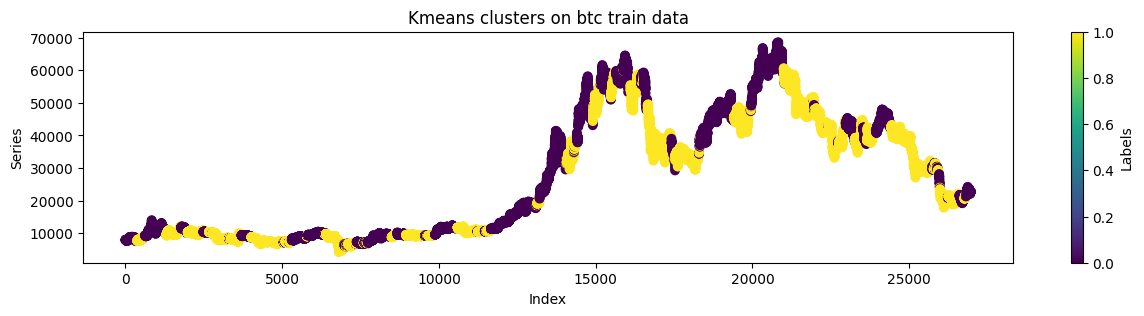

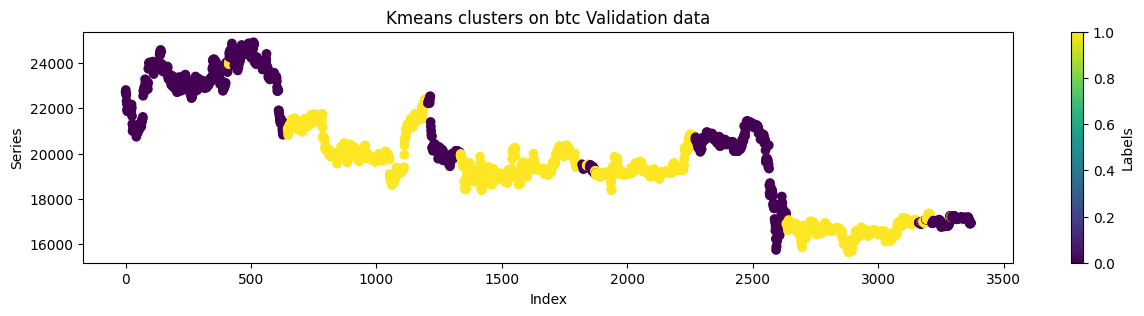

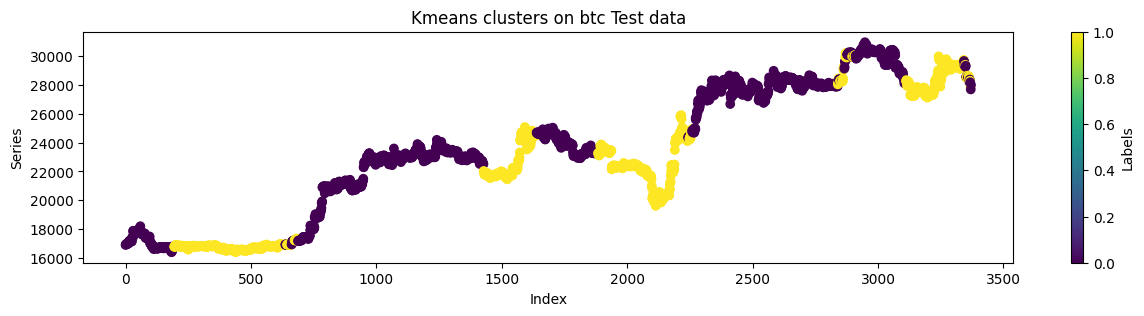

In [41]:
btc_kmeans = cluster_and_plot("btc", btc_data_dict_exp, random_state=0, n_clusters=2)

/home/azureuser/TS-FM/enter/envs/baseline/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


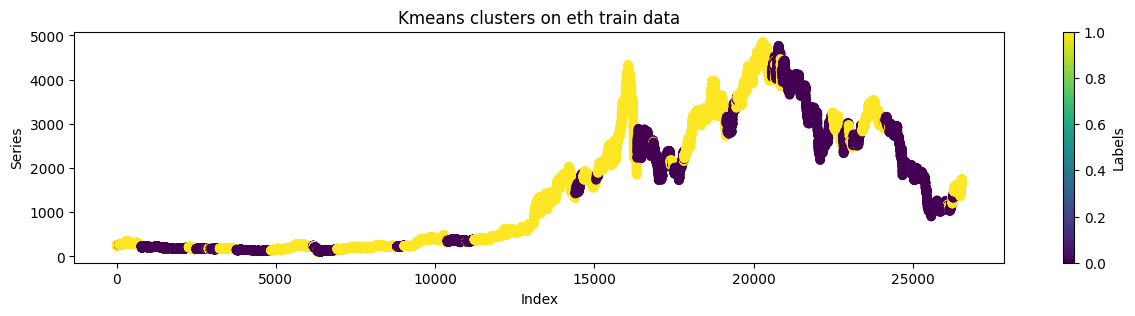

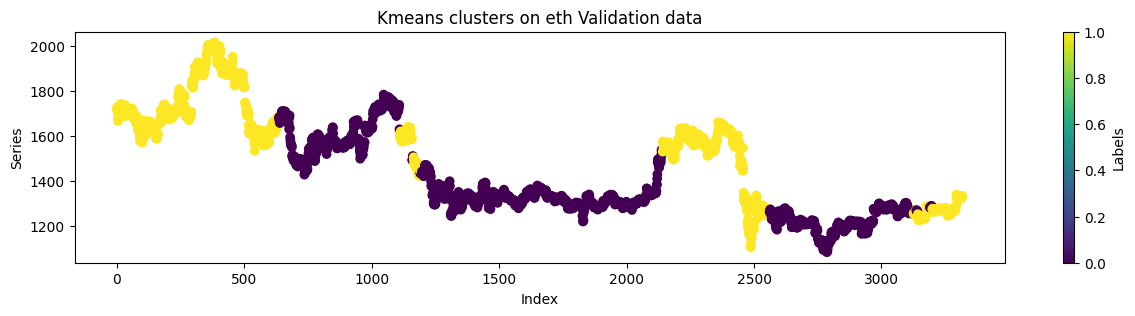

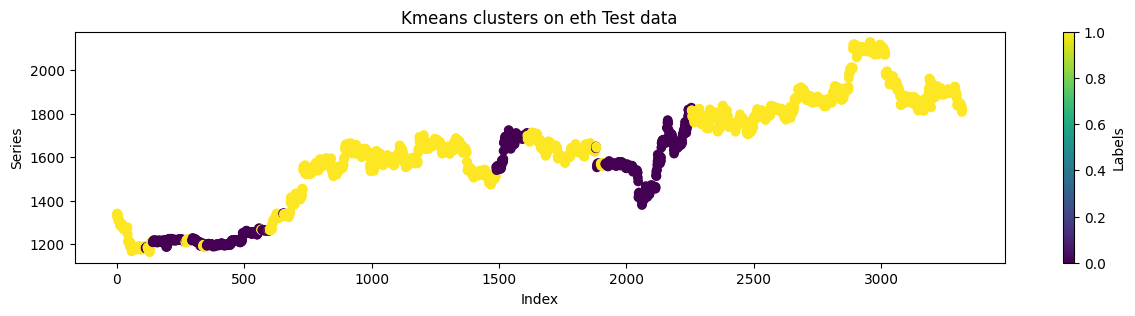

In [42]:
eth_kmeans = cluster_and_plot("eth", eth_data_dict_exp, random_state=0, n_clusters=2)

/home/azureuser/TS-FM/enter/envs/baseline/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


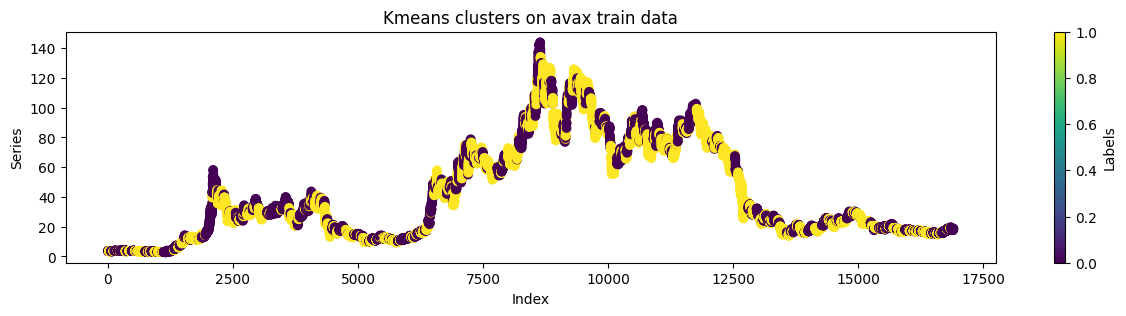

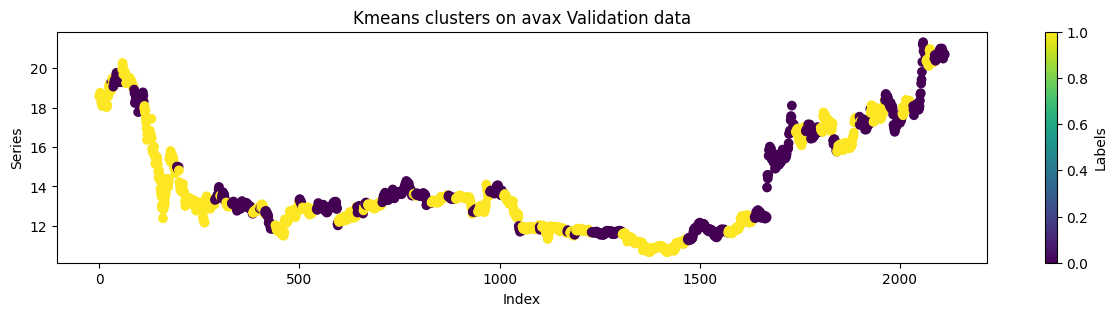

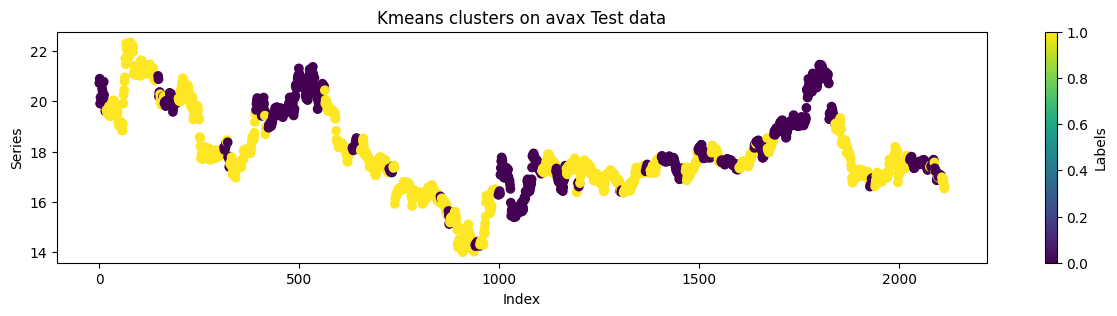

In [43]:
avax_kmeans = cluster_and_plot("avax", avax_data_dict_exp, random_state=0, n_clusters=2)

/home/azureuser/TS-FM/enter/envs/baseline/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


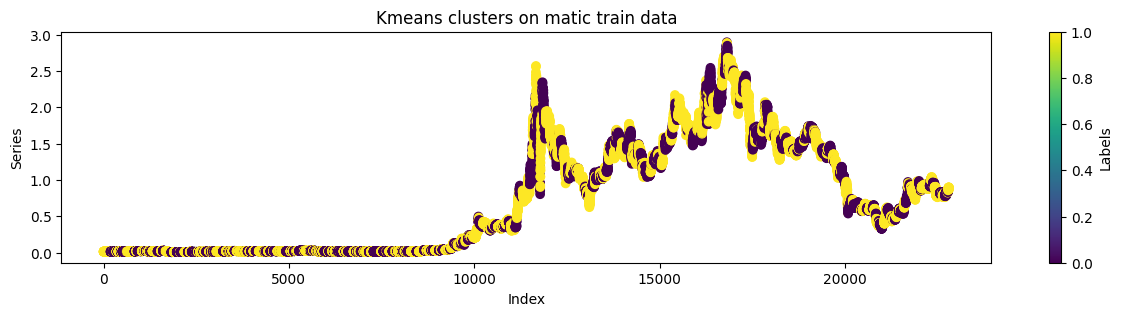

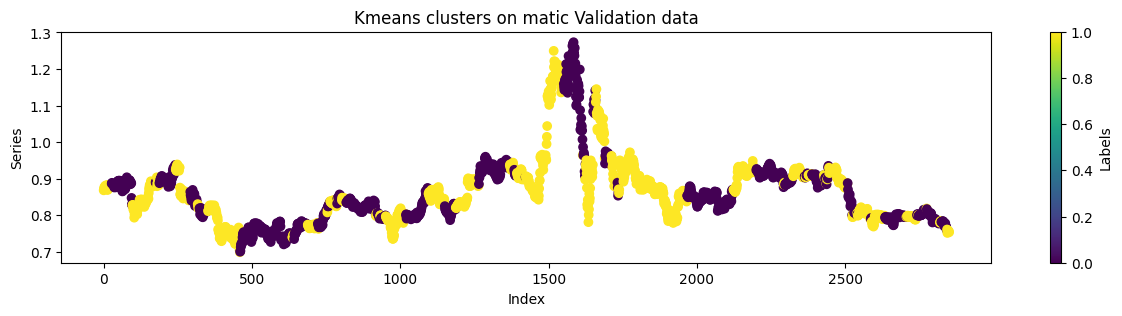

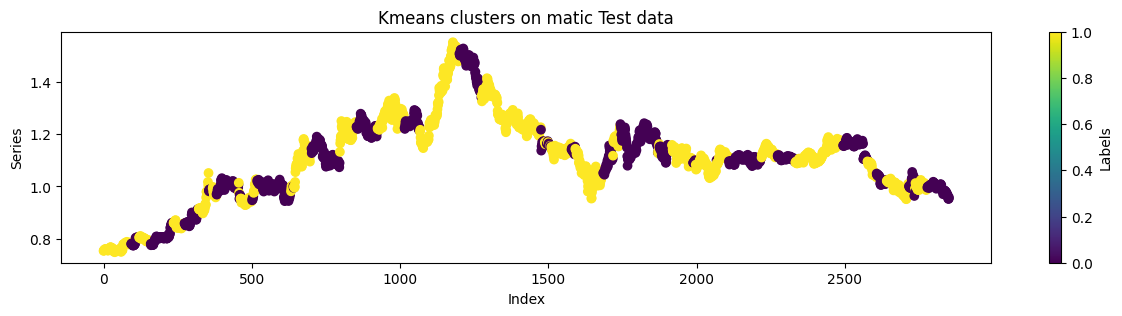

In [44]:
matic_kmeans = cluster_and_plot("matic", matic_data_dict_exp, random_state=0, n_clusters=2)